### Problem

#### Problem 1
- Given a list where each row contains a value node. This node may contain a value or may contain pointers to other nodes and an operation.
- We parse the input into nodes: Node(val, lt, rt, op)
- We do a topological sort of this DAG.
- We iterate from left to right and compute the values of Nodes which have an operation.


#### Problem 2
- `humn` node value in input is irrelevant
- Root is the result of two nodes op'ed together. One of them depends on `humn` node and one doesn't.
- Find which one depends on `humn` and one doesn't. Ignore the root child which depends on human and assign the value of the other op node to the human dependent node.
- Populate the graph as above with topological sort for all nodes besides the ones caused by humans. **The following only works because each node only appears twice, once when it's defined and once when it's used**. After populating with the topological sort algorithm, all nodes behind the \<human caused root child\>, will have one parent node whose value we know and one parent node we don't (is a descendent of human). We populate each node moving backward until we reach the human node.
- Populating backward is tricky, as we need to flip the operations that led us here. For instance, say `a/b=h` where `h` is the human caused child node. If we know `a`, then `b=a/h` but if we know `b`, then `a=b*h`. 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import typing as T
import copy
import re
import dataclasses as DC
from enum import Enum
import functools


class UnsolvableExpection(ValueError):
    pass


def do_op(lt: int, rt: int, op: str) -> int:
    if op == '+':
        return lt + rt
    elif op == '-':
        return lt - rt
    elif op == '*':
        return lt * rt
    elif op == '/':
        return lt // rt
    else:
        raise ValueError(f"Unknown operation {op}")    


@DC.dataclass
class Eqn:

    lt: 'Node'
    rt: 'Node'
    out: 'Node'
    op: str
    nodes: T.Optional[set['Node']] = None
        
    def __post_init__(self) -> None:
        self.nodes = set([self.lt, self.rt, self.out])
        
    def __repr__(self) -> str:
        return f"Eqn({self.lt.name} {self.op} {self.rt.name} = {self.out.name})"
    
    def __hash__(self) -> int:
        return hash(id(self))
    
    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, copy.deepcopy(v, memo))
        return result
    
    @staticmethod
    def is_solved(eqn: 'Eqn') -> bool:
        return Eqn.count_knowns(eqn) == 3
    
    @staticmethod
    def count_knowns(eqn) -> int:
        return sum(
            bool(n.val is not None)
            for n in eqn.nodes
        )

    @staticmethod
    def is_solvable(eqn: 'Eqn') -> bool:
        knowns = Eqn.count_knowns(eqn=eqn)
        if knowns < 2:
            return False
        elif knowns == 2:
            return True
        else:
            raise ValueError("Already solved")
    
    @staticmethod
    def solve_for_unknown(eqn: 'Eqn') -> None:
        """Of the 3 nodes in the equation, if we know 2,
        it will update the `val` of the node in place.
        
        `Side-effect`
        """
        if not Eqn.is_solvable(eqn=eqn):
            raise UnsolvableExpection(f"{repr(eqn)} is not solvable")
        opposite_op = {"+": "-", "-": "+", "*": "/", "/": "*"}
        if eqn.out.val is None:
            eqn.out.val = do_op(lt=eqn.lt.val, rt=eqn.rt.val, op=eqn.op)
        elif eqn.lt.val is None:
            # a = b / c => b = a * c; a = b + c => b = a - c
            eqn.lt.val = do_op(lt=eqn.out.val, rt=eqn.rt.val, op=opposite_op[eqn.op])
        elif eqn.rt.val is None:
            if eqn.op in {"+", "*"}:
                # a = b + c => c = a - b; a = b * c => c = a / b
                eqn.rt.val = do_op(lt=eqn.out.val, rt=eqn.lt.val, op=opposite_op[eqn.op])
            else:
                # "-", "/"
                # a = b - c => c = b - a; a = b / c => c = b / a
                eqn.rt.val = do_op(lt=eqn.lt.val, rt=eqn.out.val, op=eqn.op)
        else:
            raise RuntimeError("Should never happen")


@DC.dataclass
class Node:
    name: str
    is_leaf: bool = DC.field(init=False)
    val: T.Optional[int] = None
    lt: T.Optional[T.Union[str, 'Node']] = None
    rt: T.Optional[T.Union[str, 'Node']] = None
    out: T.Optional[T.Union['Node']] = None
    op: T.Optional[str] = None
    eqns: set['Eqn'] = DC.field(default_factory=set)

    def __post_init__(self) -> None:
        self.is_leaf = self.op is None
        
    
    @property
    def _prev(self):
        return set([self.lt, self.rt])
        
    def __repr__(self) -> str:
        lt = _node_name(self.lt)
        rt = _node_name(self.rt)
        out = _node_name(self.out)
        return (
            f"Node(name={self.name}, val={self.val}, "
            f"lt={lt}, rt={rt}, op={self.op}, out={out}, "
            f"eqns={self.eqns}"
        )
        
    def __hash__(self) -> int:
        return hash(self.name)
    
    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, copy.deepcopy(v, memo))
        return result
    
    def __eq__(self, other) -> bool:
        return self.name == other.name 


def _node_name(n: Node) -> str:
    if n is None:
        return n
    elif isinstance(n, str):
        return n
    else:
        return n.name
    
    
Graph = T.NewType('Graph', dict[str, Node])

#### Parse data

In [3]:
INPUT_FL = 'input.txt'
TEST_FL = 'test.txt'

In [4]:
def parse_fl(fl) -> Graph:
    g = {}
    with open(fl) as infile:
        for ln in infile:
            name, val_str = ln.split(":")
            try:
                g[name] = Node(name=name, val=int(val_str))
            except ValueError:
                # operation node
                lt, op, rt = re.findall(r"(\w+) ([\+\*-/]) (\w+)", val_str)[0]
                g[name] = Node(name=name, lt=lt, rt=rt, op=op)
        for name, node in g.items():
            if node.is_leaf:
                continue
            node.lt = g[node.lt]
            node.rt = g[node.rt]
            node.lt.out = node
            node.rt.out = node
            eqn = Eqn(lt=node.lt, rt=node.rt, out=node, op=node.op)
            node.lt.eqns.add(eqn)
            node.rt.eqns.add(eqn)
            node.eqns.add(eqn)
    return g

In [5]:
test_graph = parse_fl(TEST_FL)
input_graph = parse_fl(INPUT_FL)

#### Visualise graph

From andrej karpathy lectures on NN

In [6]:
from graphviz import Digraph

def draw_dot(root: Node, only_nodes: T.Optional[set[Node]]=None):
    # LR = left to right  
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    _nodes, _edges = _trace(root)
    nodes, edges = _remove_unwanted_nodes(nodes=_nodes, edges=_edges, only_nodes=only_nodes)
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=n.name, label=f"{n.name} | data {n.val}", shape="record")
        if n.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=n.name+n.op, label=n.op)
            # and connect this node to it
            dot.edge(n.name+n.op, n.name)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(n1.name, n2.name+n2.op)
    return dot


def _trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    _build_trace(v=root, nodes=nodes, edges=edges)
    return nodes, edges


def _build_trace(v, nodes, edges):
    if v not in nodes:
        nodes.add(v)
    for child in v._prev:
        if child is None:
            continue
        edges.add((child, v))
        _build_trace(v=child, nodes=nodes, edges=edges)
        
        
def _remove_unwanted_nodes(
    nodes: set[Node], edges: set[tuple[Node, Node]], only_nodes: set[Node]
) -> tuple:
    if only_nodes is None:
        return (nodes, edges)
    new_nodes = {
        n for n in nodes
        if (
            (n in only_nodes)
            or (n.out in only_nodes and n.is_leaf)
        )
    }
    new_edges = {
        (n1, n2)
        for n1, n2 in edges
        if (
            ((n1 in only_nodes) or (n2 in only_nodes and n1.is_leaf))
            and ((n2 in only_nodes) or (n1 in only_nodes and n2.is_leaf))
        )
    }
    return (new_nodes, new_edges)

##### Unpopulated test graph

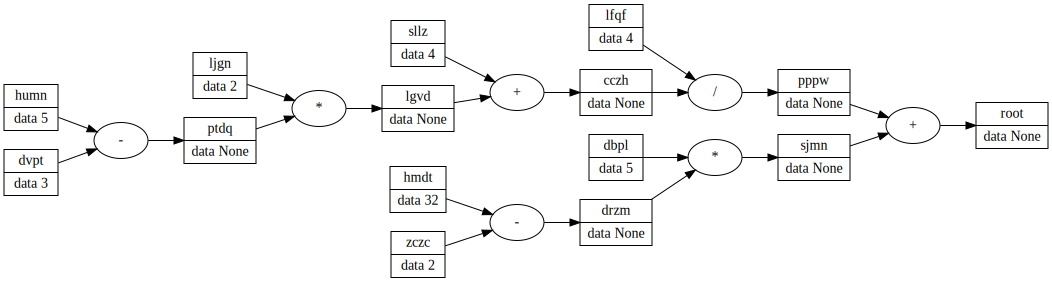

In [7]:
draw_dot(test_graph["root"])

#### Topological sort

In [8]:
@DC.dataclass
class Index:
    ix: int


def topological_sort(graph: Graph) -> list[Node]:
    n = len(graph)
    output, seen, ix = [None]*n, set(), Index(ix=0)
    for node in graph.values():
        if node not in seen:
            _ts_dfs(node=node, seen=seen, ix=ix, output=output)
    return output


def _ts_dfs(node: Node, seen: set[Node], ix: Index, output: list[Node]) -> Node:
    """Populates output with nodes in topological sort order"""
    seen.add(node)
    if node.lt and node.lt not in seen:
        _ts_dfs(node=node.lt, seen=seen, ix=ix, output=output)
    if node.rt and node.rt not in seen:
        _ts_dfs(node=node.rt, seen=seen, ix=ix, output=output)
    output[ix.ix] = node
    ix.ix += 1

In [9]:
test_ts = topological_sort(graph=test_graph)

In [10]:
print(f"{topological_sort(graph=input_graph)[-1]=}")

topological_sort(graph=input_graph)[-1]=Node(name=root, val=None, lt=vtsj, rt=tfjf, op=+, out=None, eqns={Eqn(vtsj + tfjf = root)}


### Part 1

In [11]:
def populate_graph(graph: Graph, dont_pop_nodes: T.Optional[set[Node]] = None) -> Graph:
    """Populates the DAG after performing operations.
    
    Will not populate nodes of graph which depend on nodes in `dont_pop_nodes` 
    """
    dont_pop_nodes = dont_pop_nodes if dont_pop_nodes else set()
    graph = copy.deepcopy(graph)
    graph_ts = topological_sort(graph)
    for node in graph_ts:
        if (
            node.val is not None
            or node in dont_pop_nodes
            or node.lt.val is None
            or node.rt.val is None
        ):
            continue
        node.val = do_op(lt=node.lt.val, rt=node.rt.val, op=node.op)
    return graph


def find_root_val(graph: Graph) -> int:
    return populate_graph(graph=graph)["root"].val

##### Populated graph

In [12]:
populated_test_g = populate_graph(test_graph)

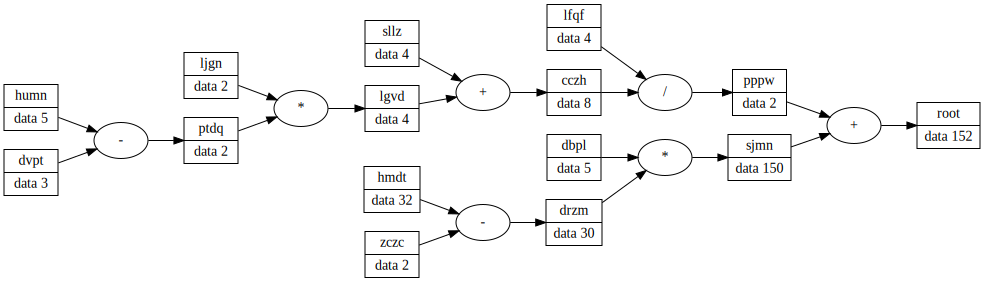

In [13]:
draw_dot(populated_test_g["root"])

In [14]:
find_root_val(graph=test_graph)

152

In [15]:
find_root_val(graph=input_graph)

379578518396784

### Part 2

In [16]:
def nodes_caused_by(graph: Graph, node: T.Union[str, Node]) -> set[Node]:
    """Find all the nodes that are caused by the target node.
    
    For instance, say we are looking for the `humn` node. The nodes
    directly affected by the human node are the nodes in the `out` variable
    in the equations of `humn`. Then we follow the out of those variables
    until we have seen all the nodes.
    
    The return set will include the target_node itself.
    """
    if isinstance(node, str):
        node = graph[node]
    caused = set()
    _with_humn_rec(
        node=node,
        graph=graph,
        caused=caused,
    )
    return caused


def _with_humn_rec(
    node: Node,
    graph: Graph,
    caused: set[Node],
) -> bool:
    """Returns if target_node was seen connected to this node
    
    Side effect: populates seen and connected.
    """
    caused.add(node)
    for eqn in node.eqns:
        if eqn.out in caused:
            continue
        _with_humn_rec(
            node=eqn.out,
            graph=graph,
            caused=caused,
        )

#### Draw only DAG caused by input node `humn`

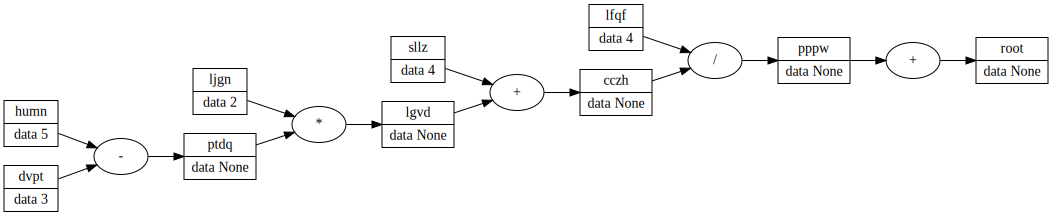

In [17]:
draw_dot(root=test_graph["root"], only_nodes=nodes_caused_by(test_graph, node="humn"))

### Populate the graph with all entries besides the ones _caused_ by `humn`

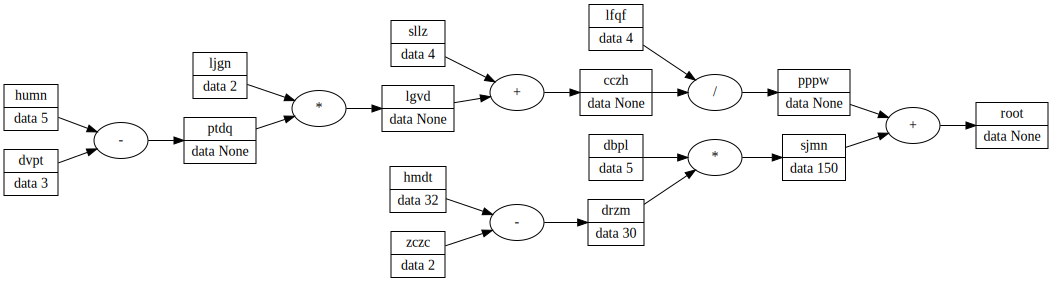

In [18]:
draw_dot(populate_graph(test_graph, dont_pop_nodes=nodes_caused_by(test_graph, node="humn"))["root"])

In [19]:
def solve_graph(graph: Graph, output_node: str, input_node: str, ignore_nodes: set[Node] = None) -> set[Node]:
    """Solves the equations in a graph recursively until we can populate
    the input_node.
    
    :param final_node: This is the output_node whose value we know.
    :param input_node: The input node whose value we need to  determine so that
        it causes the final_node to be of value we have given it.
    """
    ignore_nodes = ignore_nodes or set()
    tmp_graph = copy.deepcopy(graph)
    tmp_graph[input_node].val = None
    solved_graph = populate_graph(
        graph=tmp_graph,
        dont_pop_nodes=nodes_caused_by(graph=tmp_graph, node=input_node),
    )
    _solve_rec(
        known_root=solved_graph[output_node],
        input_node=graph[input_node],
        graph=solved_graph,
        ignore_nodes=ignore_nodes,
    )
    return solved_graph


def _solve_rec(known_root: Node, input_node: Node, graph: Graph, ignore_nodes: set[Node]) -> bool:
    lt, rt = known_root.lt, known_root.rt
    for eqn in known_root.eqns:
        if lt.is_leaf and rt.is_leaf and lt != input_node and rt != input_node:
            # Even though the input node is a leaf we should still compute it
            continue
        if eqn.nodes & ignore_nodes:
            continue
        if Eqn.is_solved(eqn):
            continue
        _handle_solve_exc(known_root, eqn)
        next_node = lt if lt.val is None else rt
        Eqn.solve_for_unknown(eqn=eqn)
        if not next_node.is_leaf:
            # This will happen for the input node
            _solve_rec(known_root=next_node, graph=graph, ignore_nodes=ignore_nodes, input_node=input_node)


def _handle_solve_exc(known_root, eqn):
    if not Eqn.is_solvable(eqn):
        raise ValueError(
            f"{known_root}'s eqn {eqn} should be solvable\n"
            f""
        )

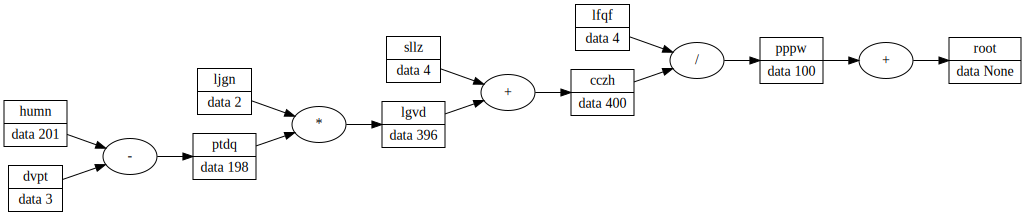

In [20]:
test_graph_copy = copy.deepcopy(test_graph)
test_graph_copy['pppw'].val = 100
draw_dot(
    solve_graph(
        graph=test_graph_copy,
        input_node="humn",
        output_node="pppw",
        ignore_nodes={test_graph_copy["root"]},
    )["root"],
    only_nodes=nodes_caused_by(test_graph, node="humn"),
)

In [21]:
def solve_prob2(graph, input_nm="humn", output_nm="root"):
    tmp_graph = copy.deepcopy(graph)
    input_caused_nodes = nodes_caused_by(graph=tmp_graph, node=input_nm)
    popped_graph = populate_graph(
        graph=tmp_graph,
        dont_pop_nodes=input_caused_nodes,
    )
    # Set the input node to None, it's descendent node attached to root to the true value.
    solved_graph = copy.deepcopy(popped_graph)
    rchild_labels = _label_root_children(
        graph=solved_graph, input_caused_nodes=input_caused_nodes, output_nm=output_nm,
    )
    solved_graph[input_nm].val = None
    human_csd_rchild = solved_graph[rchild_labels["human_caused"]]
    human_csd_rchild.val = solved_graph[rchild_labels["truth"]].val
    _solve_rec(
        known_root=human_csd_rchild,
        input_node=solved_graph[input_nm],
        graph=solved_graph,
        ignore_nodes={solved_graph[output_nm]},
    )
    return solved_graph
    
    
def _label_root_children(graph, input_caused_nodes, output_nm):
    """Finds the node the root should copy. This is the node that is an
    input to `root` but is not caused by `input_node_nm` (`humn`).
    
    {"human_caused": Node(), "truth": Node()}
    """
    poped_graph = populate_graph(graph=graph)
    output_eqn = list(poped_graph[output_nm].eqns)[0]
    if output_eqn.lt in input_caused_nodes:
        return {"human_caused": output_eqn.lt.name, "truth": output_eqn.rt.name}
    else:
        return {"human_caused": output_eqn.rt.name, "truth": output_eqn.lt.name}

In [22]:
_label_root_children(test_graph, input_caused_nodes=nodes_caused_by(graph=test_graph, node="humn"),  output_nm="root")

{'human_caused': 'pppw', 'truth': 'sjmn'}

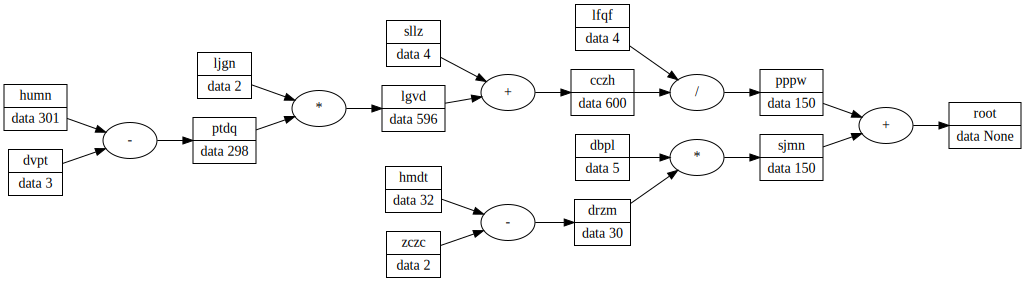

In [23]:
draw_dot(solve_prob2(graph=test_graph)["root"])